# Train a JointVAE model

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import torch

use_cuda = torch.cuda.is_available()
use_cuda

True

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # change to your device

#### Prepare data list

#### Create list of image paths

In [4]:
loadable_dresses = list(np.loadtxt('data/loadable_women_primary_dress.csv',delimiter=',',skiprows=1,dtype='str'))

In [5]:
print(len(loadable_dresses))

102125


In [6]:
loadable_dresses[:5]

['/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/6/4/6418008_9882769.jpg',
 '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/6/6/6627534_9864695.jpg',
 '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/6/7/6772508_9949243.jpg',
 '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/6/7/6758001_9588597.jpg',
 '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/6/6/6637527_9387666.jpg']

In [8]:
bad_data = ['/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/2/723739_1342692.jpg']

for bad in bad_data:
    if bad in loadable_dresses:
        del loadable_dresses[loadable_dresses.index(bad)]
        
print(len(loadable_dresses))

102124


#### Split into train and test set

In [11]:
image_paths_train = loadable_dresses[:8000]
image_paths_test = loadable_dresses[9000:11000]

print(f"Number of train image paths: {len(image_paths_train):,d}")
print(f"Number of test image paths: {len(image_paths_test):,d}")
print()
print("Sample paths:")
print(image_paths_train[0])
print(image_paths_train[-1])
print(image_paths_test[0])
print(image_paths_test[-1])

Number of train image paths: 8,000
Number of test image paths: 2,000

Sample paths:
/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/6/4/6418008_9882769.jpg
/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/1/9/1936843_2592491.jpg
/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/1/4/1479977_2107851.jpg
/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/8/1/815925_1551373.jpg


In [29]:
from torchvision import transforms
#from utils.dataloaders_custom import get_imagelist_dataloader, ImageListDataset
from utils.dataloader_tools import get_imagelist_dataloader, ImageListDataset

BATCH_SIZE = 200

composed = transforms.Compose([transforms.CenterCrop((256,256)),transforms.Resize((256,256)),transforms.ToTensor()])

# convert rgb is for the cv2 loaded images that I've got in this dir
conv_rgb = False
error_handling = True
train_dataset = ImageListDataset(image_paths_train, cut_from='top', cut_amount=256, 
                                 transform=composed, convert_rgb=conv_rgb, error_handling=True)
test_dataset = ImageListDataset(image_paths_test, cut_from='top', cut_amount=256, 
                                 transform=composed, convert_rgb=conv_rgb, error_handling=True)

train_loader = get_imagelist_dataloader(batch_size=BATCH_SIZE, dataset_object=train_dataset)
test_loader = get_imagelist_dataloader(batch_size=BATCH_SIZE, dataset_object=test_dataset)

### Define latent distribution of the model

In [23]:
# Latent distribution will be joint distribution of 10 gaussian normal distributions
# and one 10 dimensional Gumbel Softmax distribution
latent_spec = {'cont': 8,
               'disc': [8]}

### Build a model

In [24]:
from jointvae.models_256_xstyle_int_nd import VAE

model = VAE(latent_spec=latent_spec, img_size=(3, 256, 256), use_cuda=use_cuda)

In [25]:
#print(model)

### Train the model

In [26]:
from torch import optim

# Build optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4, amsgrad=True) # added amsgrad # orig lr 5e-4

In [27]:
from jointvae.training import Trainer
#from jointvae.training_debug import Trainer

# Define the capacities
# Continuous channels
cont_capacity = [0.0, 5, 20000, 32.0]  # Starting at a capacity of 0.0, increase this to 5.0
                                         # over 25000 iterations with a gamma of 30.0
# Discrete channels
disc_capacity = [0.0, 5, 20000, 32.0]  # Starting at a capacity of 0.0, increase this to 5.0
                                         # over 25000 iterations with a gamma of 30.0

# Build a trainer
trainer = Trainer(model, optimizer,
                  cont_capacity=cont_capacity,
                  disc_capacity=disc_capacity,
                 use_cuda=use_cuda)

#### Initialize visualizer

In [28]:
#from viz.visualize import Visualizer
from viz.visualize import Visualizer

viz = Visualizer(model)
viz.save_images = False # needed to add this so it returns a tensor

In [ ]:
# Train model for 10 epochs
# Note this should really be a 100 epochs and trained on a GPU, but this is just to demo

trainer.train(train_loader, epochs=60, save_training_gif=None)

0/8000	Loss: 45571.020
Epoch: 1 Average loss: 45493.91
0/8000	Loss: 45399.918
Epoch: 2 Average loss: 45027.66
0/8000	Loss: 43166.977
Epoch: 3 Average loss: 37545.39
0/8000	Loss: 34610.395
Epoch: 4 Average loss: 33206.12
0/8000	Loss: 31100.615
Epoch: 5 Average loss: 28552.38
0/8000	Loss: 26314.330
Epoch: 6 Average loss: 26564.59
0/8000	Loss: 25844.164
Epoch: 7 Average loss: 25809.21
0/8000	Loss: 25326.512
Epoch: 8 Average loss: 25261.62
0/8000	Loss: 25131.131
Epoch: 9 Average loss: 24823.17
0/8000	Loss: 24197.807
Epoch: 10 Average loss: 24442.86
0/8000	Loss: 24505.109
Epoch: 11 Average loss: 23865.16
0/8000	Loss: 23789.973
Epoch: 12 Average loss: 21527.92
0/8000	Loss: 19445.289
Epoch: 13 Average loss: 18413.69
0/8000	Loss: 17573.986
Epoch: 14 Average loss: 17376.00
0/8000	Loss: 17026.617


In [ ]:
print('hi')

In [ ]:
# Get a batch of data
for batch, labels in test_loader:
    break
print("batch: ",type(batch),batch.shape)
type(viz.reconstructions(batch))

### Visualize

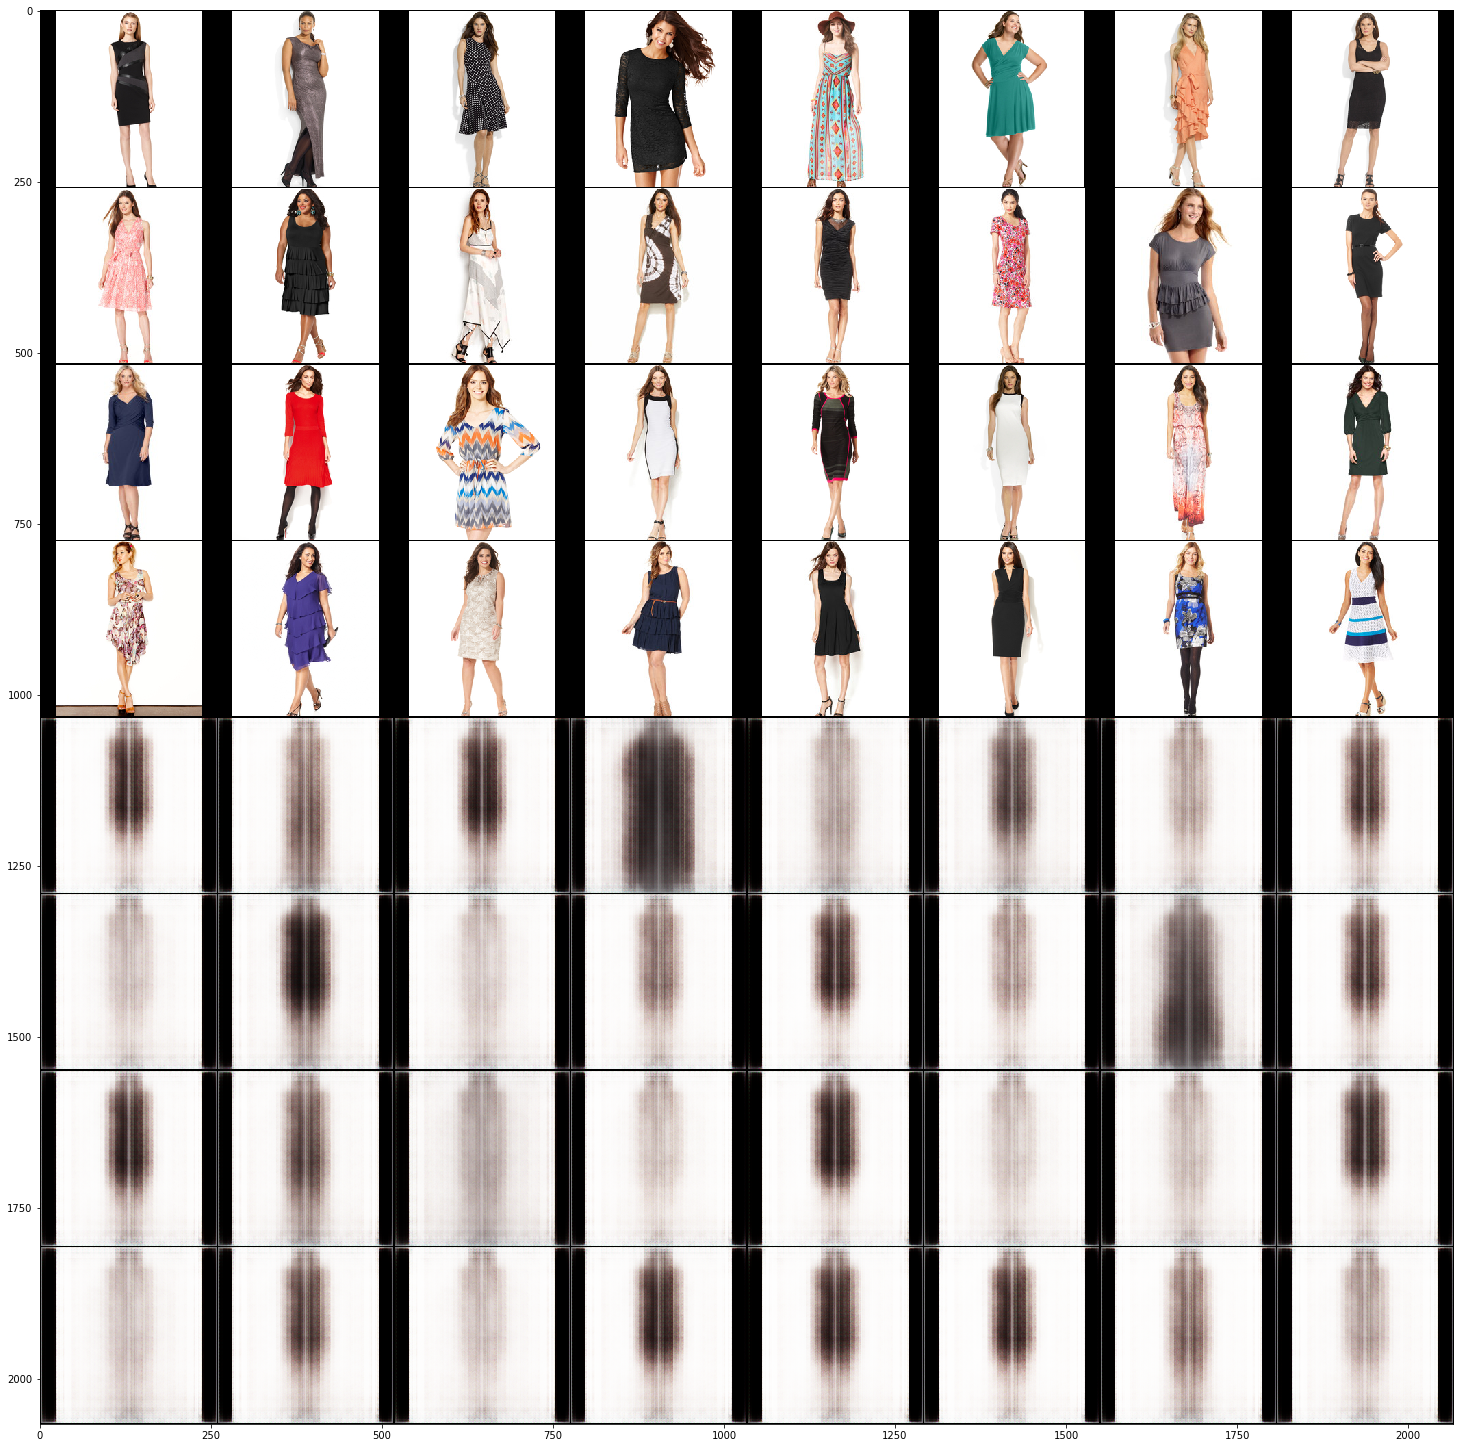

In [21]:
# Plot reconstructions
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Get a batch of data
for batch, labels in test_loader:
    break

# Reconstruct data using Joint-VAE model
recon = viz.reconstructions(batch)

plt.figure(figsize=(26,26))
plt.imshow(np.rot90(np.transpose(recon.numpy(),(2,1,0)),k=3));
plt.savefig("sample_images/305/256/xint256_e20_c10d10_cap48_30k_gam32_reconstructions.png",dpi=200)

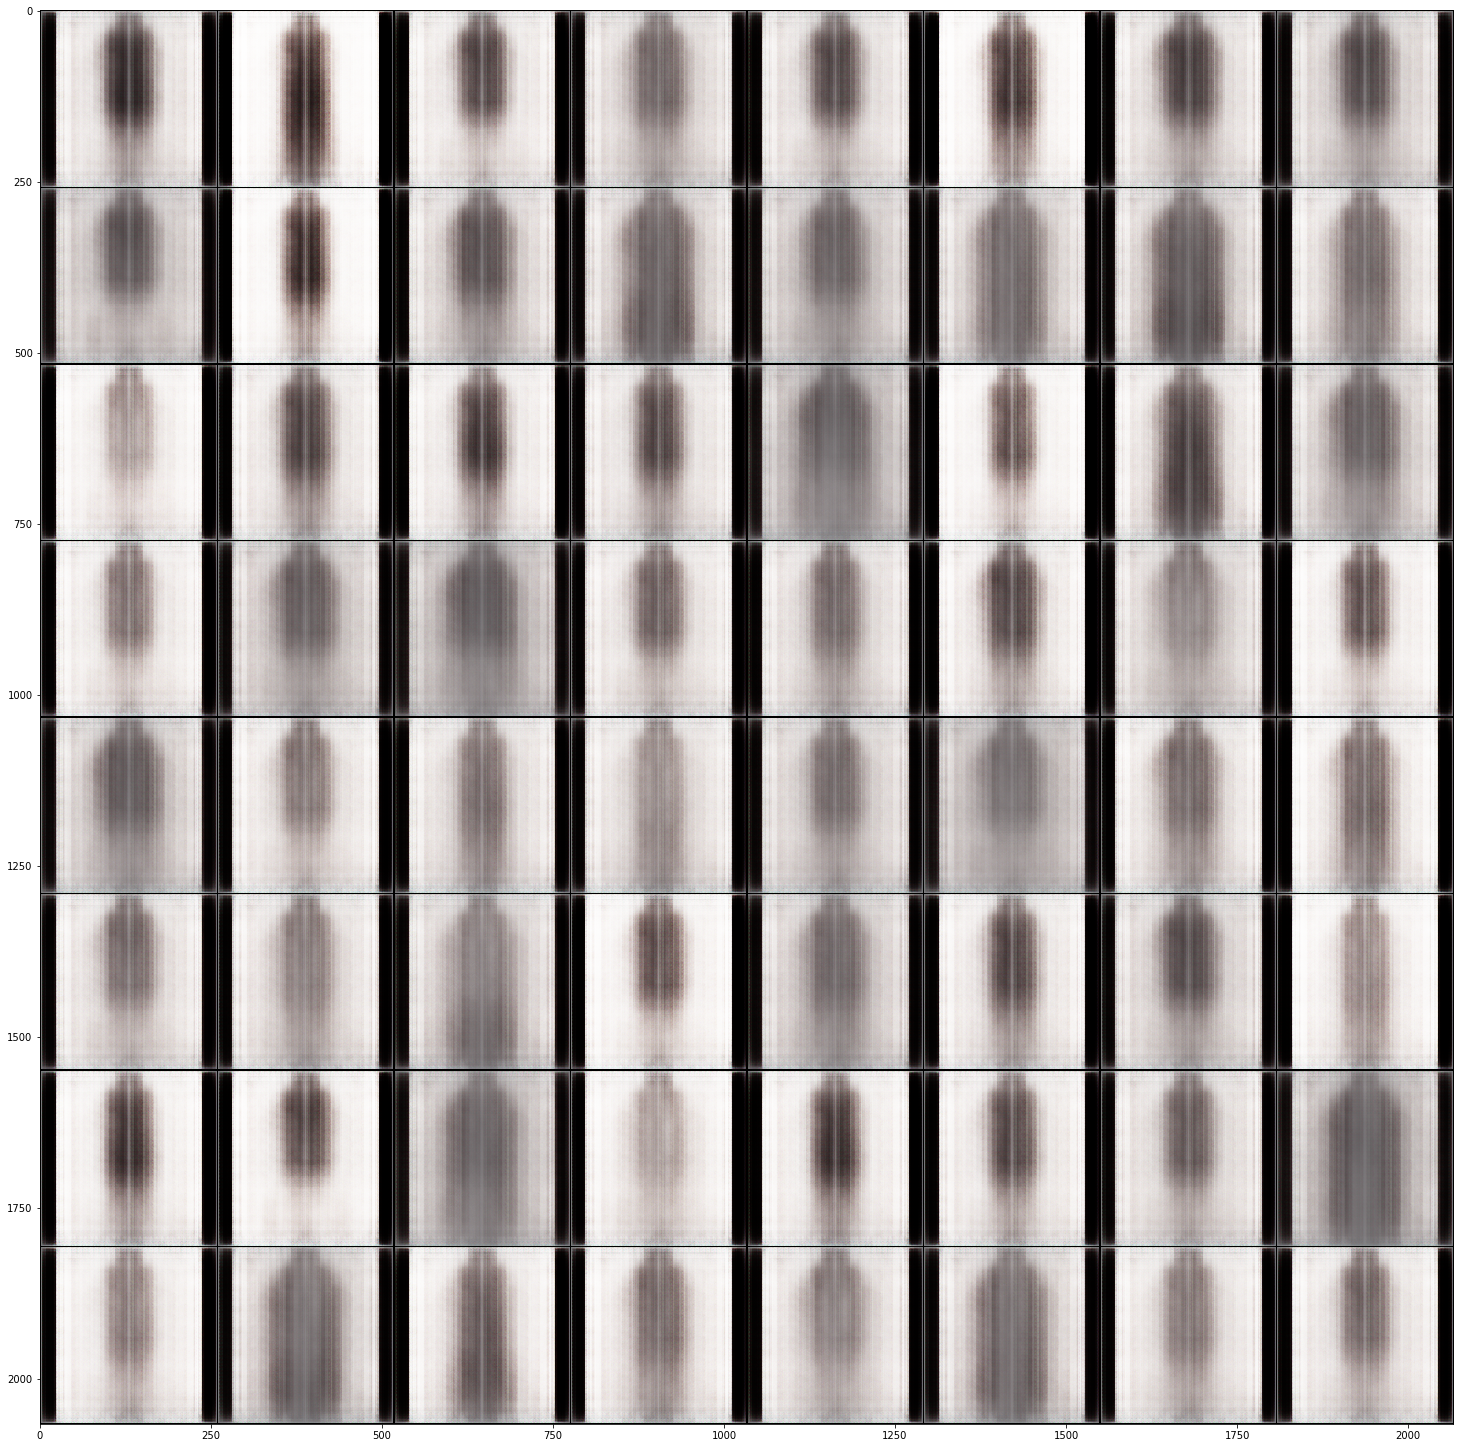

In [22]:
# Plot samples
samples = viz.samples()

plt.figure(figsize=(26,26))
plt.imshow(np.rot90(np.transpose(samples.numpy(),(2,1,0)),k=3));
plt.savefig("sample_images/305/256/xint256_e20_c10d10_cap48_30k_gam32_samples.png",dpi=200)

#### Traverses all latent dimensions one by one and plots a grid of images where each row corresponds to a latent traversal of one latent dimension

In [ ]:
# Plot all traversals
traversals = viz.all_latent_traversals(size=10)

plt.figure(figsize=(20,20))
plt.imshow(np.rot90(np.transpose(traversals.numpy(),(2,1,0)),k=3));
plt.savefig("sample_images/home/256/xint256_e600_b100_c10d10_cap48_30k_gam32_all_traversals_n20.png",dpi=200)

In [ ]:
# Plot a grid of some traversals
traversals = viz.latent_traversal_grid(cont_idx=2, cont_axis=1, disc_idx=0, disc_axis=0, size=(10, 10))

plt.figure(figsize=(20,20))
plt.imshow(np.rot90(np.transpose(traversals.numpy(),(2,1,0)),k=3));
plt.savefig("sample_images/home/256/xint256_e600_b100_c10d10_cap48_30k_gam32_traversals2100.png",dpi=200)

In [ ]:
# Plot a grid of some traversals
traversals = viz.latent_traversal_grid(cont_idx=1, cont_axis=1, disc_idx=0, disc_axis=0, size=(10, 10))

plt.figure(figsize=(20,20))
plt.imshow(traversals.numpy()[0, :, :]);
plt.imshow(np.rot90(np.transpose(traversals.numpy(),(2,1,0)),k=3));
plt.savefig("sample_images/home/256/xint256_e600_b100_c10d10_cap48_30k_gam32_traversals1100.png",dpi=200)

In [ ]:
# Plot a grid of some traversals
traversals = viz.latent_traversal_grid(cont_idx=9, cont_axis=1, disc_idx=0, disc_axis=0, size=(10, 10))

plt.figure(figsize=(20,20))
plt.imshow(np.rot90(np.transpose(traversals.numpy(),(2,1,0)),k=3));
plt.savefig("sample_images/home/256/xint256_e600_b100_c10d10_cap48_30k_gam32_traversals9100.png",dpi=200)

In [ ]:
!ls

### Save Model

In [ ]:
model_name = "xint256_e600_b100_c10d10_cap48_30k_gam32.pth"

In [ ]:
torch.save(model.state_dict(),"trained_models" + "statedict_" + model_name) # save state dict
#torch.save(model, model_name) # save full model

In [ ]:
print("Done training: ",model_name)

#### Restore Model from State Dict

In [ ]:
sd_model = VAE(latent_spec=latent_spec, img_size=(3, 64, 64))
sd_model.load_state_dict(torch.load("statedict_" + model_name))

#### Restore Full Model
* Note in this case the serialized data is bound to the specific classes and exact directory strucutre used.

In [ ]:
full_model = torch.load(model_name)

In [ ]:
type(full_model)

In [ ]:
type(sd_model)

In [ ]:
!ls